In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.decomposition import PCA
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, Flatten, Conv1D
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from scipy.signal import lfilter
import solverFunctions as sf
import analysisFunctions as af
from scipy.interpolate import LinearNDInterpolator

In [2]:
def GetFlow(order_bc,continuous=False):
    if continuous:
        con_str = "C"
    else:
        con_str = "DC"
    u = np.load(r"DataDC/dataset"+con_str+"_u_30_1_"+str(order_bc)+".npy")
    v = np.load(r"DataDC/dataset"+con_str+"_v_30_1_"+str(order_bc)+".npy")
    p = np.load(r"DataDC/dataset"+con_str+"_p_30_1_"+str(order_bc)+".npy")
    return u,v,p

data = list(zip(GetFlow(1),GetFlow(2),GetFlow(3),GetFlow(5),GetFlow(4,True)))
# data = list(zip(GetFlow(1),GetFlow(3)))
u = np.concatenate(data[0],axis=0)
v = np.concatenate(data[1],axis=0)
p = np.concatenate(data[2],axis=0)

p.shape

(27066, 30, 30)

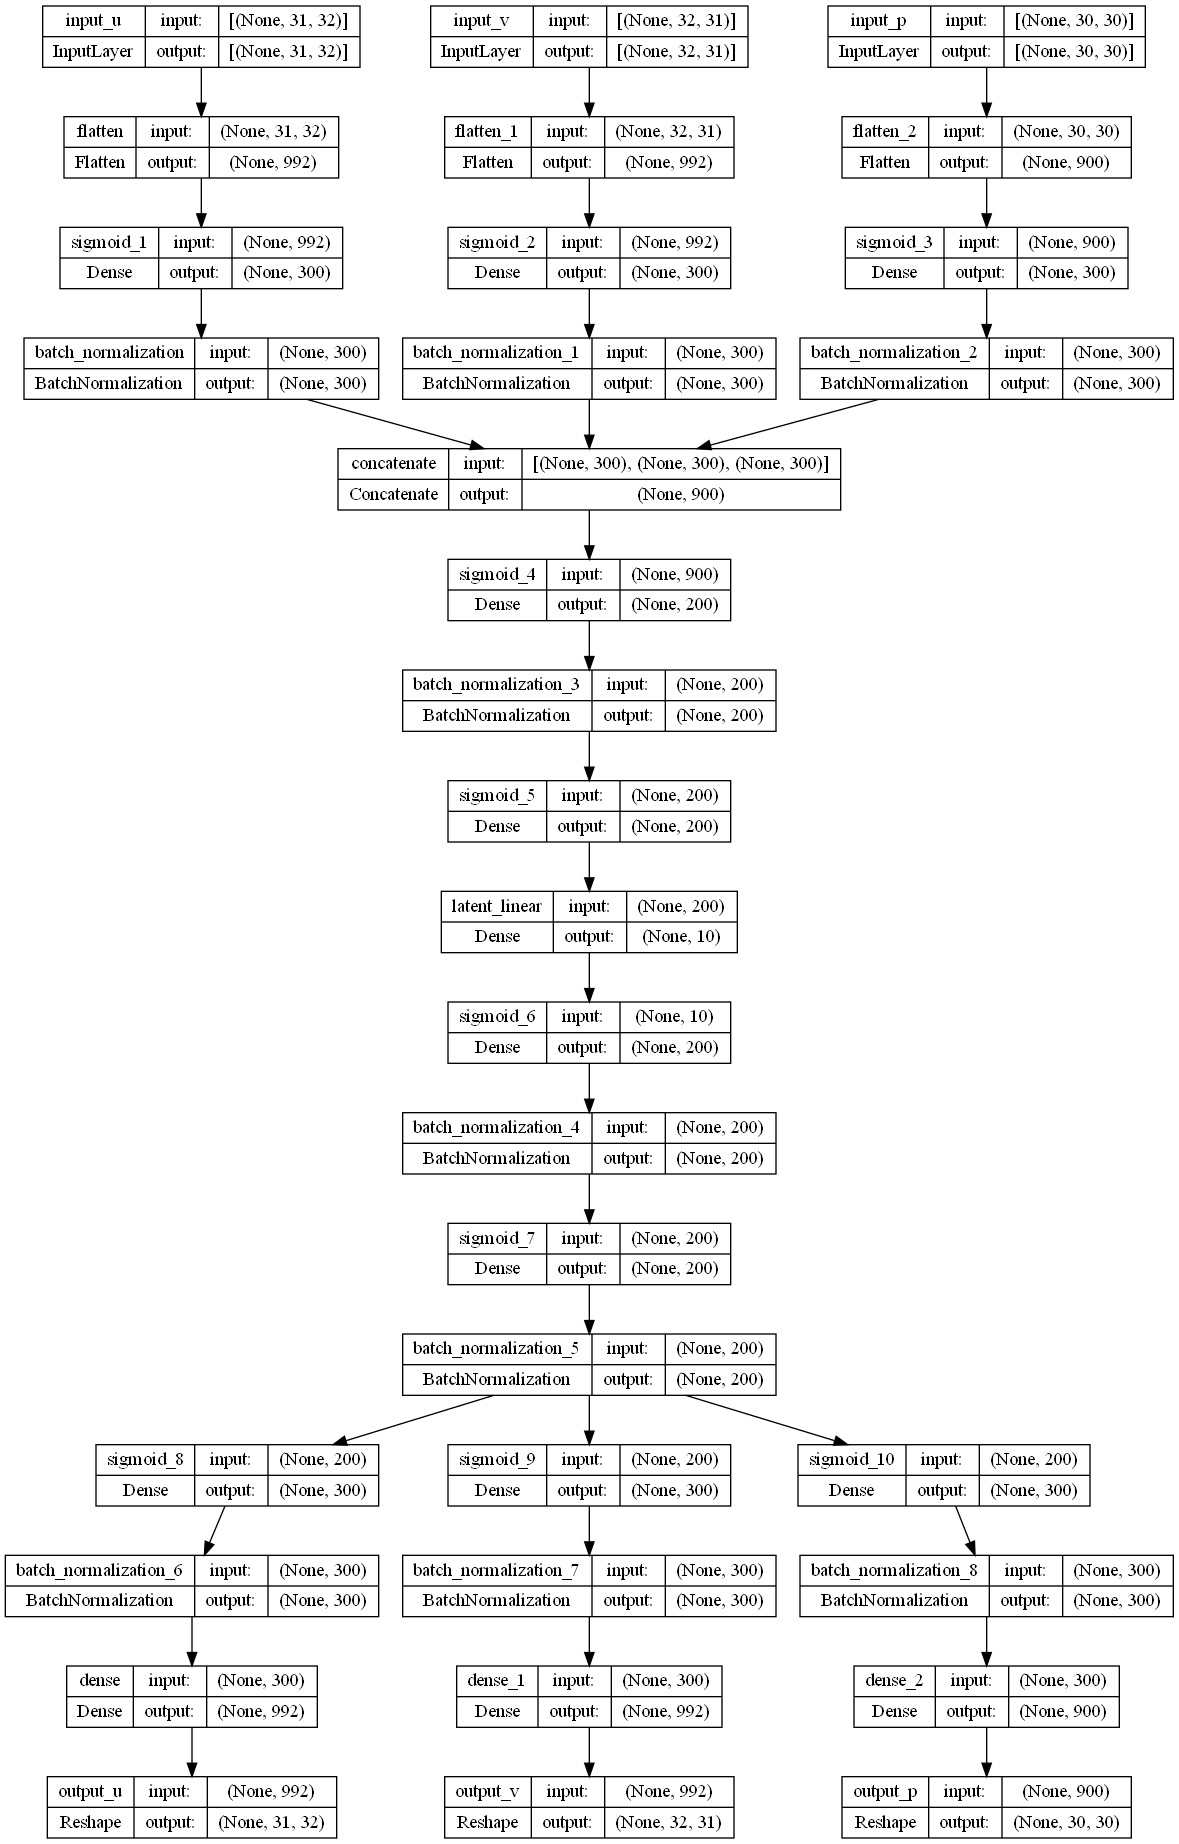

In [3]:
def GetEncoderStaggered(n_latent,input_shapes):
    input_u = Input(shape=input_shapes[0], name='input_u')
    input_v = Input(shape=input_shapes[1], name='input_v')
    input_p = Input(shape=input_shapes[2], name='input_p')
    x_u = Flatten()(input_u)
    x_v = Flatten()(input_v)
    x_p = Flatten()(input_p)
    x = Concatenate()([x_u,x_v,x_p])
    latent = Dense(n_latent)(x)
    encoder = Model([input_u,input_v,input_p],latent,name="encoder")
    return encoder,input_u,input_v,input_p,latent

def GetDecoderStaggered(n_latent,input_shapes,latent):
    # input_latent = Input(shape=(n_latent,))
    input_latent = latent
    output_u = Dense(np.prod(input_shapes[0]),use_bias=False)(input_latent)
    output_u = Reshape(input_shapes[0],name="output_u")(output_u)
    output_v = Dense(np.prod(input_shapes[1]),use_bias=False)(input_latent)
    output_v = Reshape(input_shapes[1],name="output_v")(output_v)
    output_p = Dense(np.prod(input_shapes[2]),use_bias=False)(input_latent)
    output_p = Reshape(input_shapes[2],name="output_p")(output_p)
    decoder = Model(input_latent,[output_u,output_v,output_p],name="decoder")
    return decoder,input_latent,output_u,output_v,output_p

def GetAEStaggered(input_shapes,n_latent):
    encoder,input_u,input_v,input_p,latent = GetEncoderStaggered(n_latent,input_shapes)
    decoder,input_latent,output_u,output_v,output_p = GetDecoderStaggered(n_latent,input_shapes,latent)
    model = Model([input_u,input_v,input_p], [output_u,output_v,output_p],name="model_staggered")
    
    return model, encoder, decoder

def GetEncoderStaggeredNL(n_latent,input_shapes):
    input_u = Input(shape=input_shapes[0], name='input_u')
    input_v = Input(shape=input_shapes[1], name='input_v')
    input_p = Input(shape=input_shapes[2], name='input_p')

    x_u = Flatten()(input_u)
    x_u = Dense(300,activation='sigmoid',name='sigmoid_1')(x_u)
    x_u = BatchNormalization()(x_u)

    x_v = Flatten()(input_v)
    x_v = Dense(300,activation='sigmoid',name='sigmoid_2')(x_v)
    x_v = BatchNormalization()(x_v)

    x_p = Flatten()(input_p)
    x_p = Dense(300,activation='sigmoid',name='sigmoid_3')(x_p)
    x_p = BatchNormalization()(x_p)

    x = Concatenate()([x_u,x_v,x_p])
    x = Dense(200,activation='sigmoid',name='sigmoid_4')(x)
    x = BatchNormalization()(x)
    x = Dense(200,activation='sigmoid',name='sigmoid_5')(x)

    latent = Dense(n_latent,name='latent_linear')(x)
    encoder = Model([input_u,input_v,input_p],latent,name="encoder")
    return encoder,input_u,input_v,input_p,latent

def GetDecoderStaggeredNL(n_latent,input_shapes,latent):
    # input_latent = Input(shape=(n_latent,))
    input_latent = latent
    x = Dense(200,activation='sigmoid',name='sigmoid_6')(input_latent)
    x = BatchNormalization()(x)
    x = Dense(200,activation='sigmoid',name='sigmoid_7')(x)
    x = BatchNormalization()(x)

    x_u = Dense(300,activation='sigmoid',name='sigmoid_8')(x)
    x_u = BatchNormalization()(x_u)
    output_u = Dense(np.prod(input_shapes[0]),use_bias=False)(x_u)
    output_u = Reshape(input_shapes[0],name="output_u")(output_u)

    x_v = Dense(300,activation='sigmoid',name='sigmoid_9')(x)
    x_v = BatchNormalization()(x_v)
    output_v = Dense(np.prod(input_shapes[1]),use_bias=False)(x_v)
    output_v = Reshape(input_shapes[1],name="output_v")(output_v)

    x_p = Dense(300,activation='sigmoid',name='sigmoid_10')(x)
    x_p = BatchNormalization()(x_p)
    output_p = Dense(np.prod(input_shapes[2]),use_bias=False)(x_p)
    output_p = Reshape(input_shapes[2],name="output_p")(output_p)

    decoder = Model(input_latent,[output_u,output_v,output_p],name="decoder")
    return decoder,input_latent,output_u,output_v,output_p

def GetAEStaggeredNL(input_shapes,n_latent):
    # input_u = Input(shape=input_shapes[0], name='input_u')
    # input_v = Input(shape=input_shapes[1], name='input_v')
    # input_p = Input(shape=input_shapes[2], name='input_p')
    encoder,input_u,input_v,input_p,latent = GetEncoderStaggeredNL(n_latent,input_shapes)
    decoder,input_latent,output_u,output_v,output_p = GetDecoderStaggeredNL(n_latent,input_shapes,latent)
    model = Model([input_u,input_v,input_p], [output_u,output_v,output_p],name="model_staggered")
    
    return model, encoder, decoder

n_latent = 10
input_shapes = (u[0].shape,v[0].shape,p[0].shape)
modelNL, encoderNL, decoderNL = GetAEStaggeredNL(input_shapes,n_latent)
tf.keras.utils.plot_model(modelNL, show_shapes=True)

In [14]:
optimizer = tf.keras.optimizers.Adam(0.0005)
model, encoder, decoder = GetAEStaggeredNL(input_shapes,n_latent)
model.load_weights("MLmodels/NS_10D_NLv6")

# model, encoder, decoder = GetAEStaggered(input_shapes,n_latent)
# model.load_weights("MLmodels/NS_10D_Lv5")

def con_res_loss(u,v,prob):
    mp_e = prob.rho*prob.dy_p*u[:,1:,1:-1]
    mp_w = prob.rho*prob.dy_p*u[:,:-1,1:-1]
    mp_n = prob.rho*prob.dx_p*v[:,1:-1,1:]
    mp_s = prob.rho*prob.dx_p*v[:,1:-1,:-1]
    dmp = mp_w+mp_s-mp_e-mp_n
    con_res = tf.reduce_mean(tf.square(dmp),axis=(1,2))
    return con_res

def u_res_loss(u,v,p,prob):
    mu_e = prob.rho*prob.dy_u*(u[:,1:-1,1:-1]+u[:,2:,1:-1])/2
    mu_w = prob.rho*prob.dy_u*(u[:,:-2,1:-1]+u[:,1:-1,1:-1])/2
    mu_n = prob.rho*prob.dx_u*(v[:,1:-2,1:]+v[:,2:-1,1:])/2
    mu_s = prob.rho*prob.dx_u*(v[:,1:-2,:-1]+v[:,2:-1,:-1])/2
    convection = -(mu_e*(u[:,2:,1:-1]+u[:,1:-1,1:-1])/2\
    + mu_n*(u[:,1:-1,2:]+u[:,1:-1,1:-1])/2\
    - mu_w*(u[:,:-2,1:-1]+u[:,1:-1,1:-1])/2\
    - mu_s*(u[:,1:-1,:-2]+u[:,1:-1,1:-1])/2)
    diffusion = prob.Aud_x[:-1,:]*(u[:,1:-1,1:-1]-u[:,:-2,1:-1]) + prob.Aud_x[1:,:]*(u[:,1:-1,1:-1]-u[:,2:,1:-1]) +\
        prob.Aud_y[:,:-1]*(u[:,1:-1,1:-1]-u[:,1:-1,:-2]) + prob.Aud_y[:,1:]*(u[:,1:-1,1:-1]-u[:,1:-1,2:])
    pressure = prob.dy_u*(p[:,1:,:]-p[:,:-1,:])
    u_res = tf.reduce_mean(tf.square(convection-diffusion-pressure),axis=(1,2))
    return u_res

def v_res_loss(u,v,p,prob):
    mv_e = prob.rho*prob.dy_v*(u[:,1:,1:-2]+u[:,1:,2:-1])/2
    mv_w = prob.rho*prob.dy_v*(u[:,:-1,1:-2]+u[:,:-1,2:-1])/2
    mv_n = prob.rho*prob.dx_v*(v[:,1:-1,1:-1]+v[:,1:-1,2:])/2
    mv_s = prob.rho*prob.dx_v*(v[:,1:-1,1:-1]+v[:,1:-1,:-2])/2
    convection = -(mv_e*(v[:,2:,1:-1]+v[:,1:-1,1:-1])/2\
    + mv_n*(v[:,1:-1,2:]+v[:,1:-1,1:-1])/2\
    - mv_w*(v[:,:-2,1:-1]+v[:,1:-1,1:-1])/2\
    - mv_s*(v[:,1:-1,:-2]+v[:,1:-1,1:-1])/2)
    diffusion = prob.Avd_x[:-1,:]*(v[:,1:-1,1:-1]-v[:,:-2,1:-1]) + prob.Avd_x[1:,:]*(v[:,1:-1,1:-1]-v[:,2:,1:-1]) +\
        prob.Avd_y[:,:-1]*(v[:,1:-1,1:-1]-v[:,1:-1,:-2]) + prob.Avd_y[:,1:]*(v[:,1:-1,1:-1]-v[:,1:-1,2:])
    pressure = prob.dx_v*(p[:,:,1:]-p[:,:,:-1])
    v_res = tf.reduce_mean(tf.square(convection-diffusion-pressure),axis=(1,2))
    return v_res

def ae_loss_function(x,x_r,r_weights,fd_weight,prob):
    reconstruction_u_loss = tf.reduce_mean(tf.square(x[0]-x_r[0]), axis=(1,2))
    reconstruction_v_loss = tf.reduce_mean(tf.square(x[1]-x_r[1]), axis=(1,2))
    reconstruction_p_loss = tf.reduce_mean(tf.square(x[2]-x_r[2]), axis=(1,2))
    reconstruction_loss = r_weights[0] * reconstruction_u_loss\
        + r_weights[1] * reconstruction_v_loss\
        + r_weights[2] * reconstruction_p_loss
    # finite_difference_loss = con_res_loss(x_r[0],x_r[1],prob) + u_res_loss(x_r[0],x_r[1],x_r[2],prob) + v_res_loss(x_r[0],x_r[1],x_r[2],prob)
    finite_difference_loss = tf.math.log(con_res_loss(x_r[0],x_r[1],prob)) + tf.math.log(u_res_loss(x_r[0],x_r[1],x_r[2],prob)) + tf.math.log(v_res_loss(x_r[0],x_r[1],x_r[2],prob))
    # loss = reconstruction_loss + fd_weight*finite_difference_loss
    loss = reconstruction_loss + fd_weight*finite_difference_loss
    return loss, reconstruction_loss, reconstruction_u_loss, reconstruction_v_loss, reconstruction_p_loss, finite_difference_loss

@tf.function
def train_step_VAE(x,r_weights,fd_weight,prob):
# def train_step_VAE(model,optimizer,x,r_weights,fd_weight,prob):
    with tf.GradientTape() as tape:
        
        x_r = model(x)
        # x[0] = tf.cast(x[0],tf.float32)
        # x[1] = tf.cast(x[1],tf.float32)
        # x[2] = tf.cast(x[2],tf.float32)

        loss,r_loss,r_u_loss,r_v_loss,r_p_loss,fd_loss = ae_loss_function(x,x_r, r_weights, fd_weight,prob)

    grads = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    return loss,r_loss,r_u_loss,r_v_loss,r_p_loss,fd_loss

class History():
    def __init__(self,n):
        self.loss = np.zeros(n)
        self.r_loss = np.zeros(n)
        self.r_u_loss = np.zeros(n)
        self.r_v_loss = np.zeros(n)
        self.r_p_loss = np.zeros(n)
        self.l_loss = np.zeros(n)
        self.fd_loss = np.zeros(n)
        
    def add(self,history):
        self.loss = np.concatenate([self.loss,history.loss],axis=0)
        self.r_loss = np.concatenate([self.r_loss,history.r_loss],axis=0)
        self.r_u_loss = np.concatenate([self.r_u_loss,history.r_u_loss],axis=0)
        self.r_v_loss = np.concatenate([self.r_v_loss,history.r_v_loss],axis=0)
        self.r_p_loss = np.concatenate([self.r_p_loss,history.r_p_loss],axis=0)
        self.l_loss = np.concatenate([self.l_loss,history.l_loss],axis=0)
        self.fd_loss = np.concatenate([self.fd_loss,history.fd_loss],axis=0)

def train_VAE(model,optimizer,x,n_epochs,n_batch,prob,r_weights=0.005,fd_weight=1,modelPath=None):
    n_steps = n_epochs#*len(range(0,x[0].shape[0],n_batch))
    history = History(n_steps)
    index = 0
    loss_min = np.inf
    x[0] = tf.cast(x[0],tf.float32)
    x[1] = tf.cast(x[1],tf.float32)
    x[2] = tf.cast(x[2],tf.float32)
    r_weights = tf.cast(r_weights,tf.float32)
    loss_epoch = np.zeros((x[0].shape[0]))
    r_loss_epoch = np.zeros((x[0].shape[0]))
    ru_loss_epoch = np.zeros((x[0].shape[0]))
    rv_loss_epoch = np.zeros((x[0].shape[0]))
    rp_loss_epoch = np.zeros((x[0].shape[0]))
    fd_loss_epoch = np.zeros((x[0].shape[0]))
    
    for epoch in range(n_epochs):
        indices = tf.range(start=0, limit=tf.shape(x[0])[0], dtype=tf.int32)
        idx = tf.random.shuffle(indices)
        x[0] = tf.gather(x[0],idx)
        x[1] = tf.gather(x[1],idx)
        x[2] = tf.gather(x[2],idx)
#         x_train_shuffled = tf.cast(x_train_shuffled,tf.float32)


        for batch in range(0,x[0].shape[0],n_batch):
            x_batch = [x[0][batch:batch+n_batch],x[1][batch:batch+n_batch],x[2][batch:batch+n_batch]]
            # loss,r_loss,r_u_loss,r_v_loss,r_p_loss,fd_loss = train_step_VAE(model,optimizer,x_batch,r_weights,fd_weight,prob)
            loss,r_loss,r_u_loss,r_v_loss,r_p_loss,fd_loss = train_step_VAE(x_batch,r_weights,fd_weight,prob)
            # history.loss[index] = tf.reduce_mean(loss)
            # history.r_loss[index] = tf.reduce_mean(r_loss)
            # history.r_u_loss[index] = tf.reduce_mean(r_u_loss)
            # history.r_v_loss[index] = tf.reduce_mean(r_v_loss)
            # history.r_p_loss[index] = tf.reduce_mean(r_p_loss)
            # history.fd_loss[index] = tf.reduce_mean(fd_loss)
            # history.l_loss[index] = tf.reduce_mean(l_loss)
            loss_epoch[batch:batch+loss.shape[0]] = loss
            r_loss_epoch[batch:batch+loss.shape[0]] = r_loss
            ru_loss_epoch[batch:batch+loss.shape[0]] = r_u_loss
            rv_loss_epoch[batch:batch+loss.shape[0]] = r_v_loss
            rp_loss_epoch[batch:batch+loss.shape[0]] = r_p_loss
            fd_loss_epoch[batch:batch+loss.shape[0]] = fd_loss

            
            print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}".format(epoch+1,n_epochs, 100*batch/x[0].shape[0],loss_epoch.mean()),end="\t") #
        
        history.loss[index] = loss_epoch.mean()
        history.r_loss[index] = r_loss_epoch.mean()
        history.r_u_loss[index] = ru_loss_epoch.mean()
        history.r_v_loss[index] = rv_loss_epoch.mean()
        history.r_p_loss[index] = rp_loss_epoch.mean()
        history.fd_loss[index] = fd_loss_epoch.mean()
        index+=1
            
        # print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}".format(epoch+1,n_epochs, 100,loss_epoch.mean()),end="\n")
        if (modelPath!=None) and (loss_epoch.mean()<loss_min):
            try:
                loss_min = loss_epoch.mean()
                model.save_weights(modelPath)
                print("model saved; loss = {}".format(loss_min))
            except:
                print("unable to save")
            
    return history

In [18]:
from copy import copy
r_loss_arrNL,fd_loss_arrNL,history_arrNL=copy(r_loss_arr),copy(fd_loss_arr),copy(history_arr)

In [23]:
fd_loss_arrL = [-48.479347086865346,-51.42157162783513,-53.76731647342622,-66.25583923670773,-71.12822672551411,-77.11657355403034]
r_loss_arrL = [0.5307176621114614,0.5821425441477591,0.6887396577685939,1.6338482967658812,1.901242084283033,2.5769441301063716]

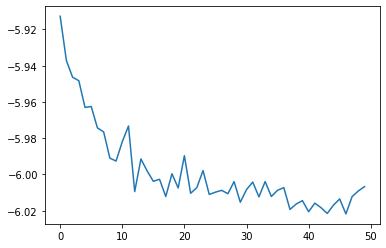

In [29]:
plt.plot(history_arrNL[4].loss)


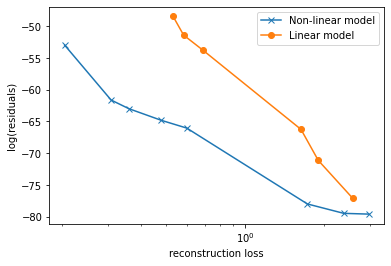

In [24]:
plt.plot(r_loss_arrNL,fd_loss_arrNL,'-x')
plt.plot(r_loss_arrL,fd_loss_arrL,'-o')
plt.gca().set_xscale('log')
plt.xlabel("reconstruction loss")
plt.ylabel("log(residuals)")
plt.legend(["Non-linear model","Linear model"])

In [36]:

n_latent = 10
r_weights = [1/u.var(),1/v.var(),1/p.var()]
fd_weights = [0.003,0.03,0.05,0.08,0.1,0.3,0.5,1]
r_loss_arr = []
fd_loss_arr = []
history_arr = []
# modelPath = "MLmodels/NS_10D_Lv5"
n_epochs = 30
n_batch = 128
u_in = u[:]
v_in = v[:]
p_in = p[:]
x = [u_in,v_in,p_in]
input_shapes = (u[0].shape,v[0].shape,p[0].shape)
prob = sf.GetProblem(30,1)
# model.load_weights("MLmodels/NS_10D_Lv5")
# modelNL.load_weights("MLmodels/NS_10D_NLv6")
def GetData(fd_weight):
    try:
        model.load_weights("MLmodels/NLsweep/NS_10D_NLfd"+str(fd_weight))
    except:
        print("Error loading fd_weight = "+str(fd_weight))
    # optimizer = tf.keras.optimizers.Adam(0.0005)
    history = train_VAE(model,optimizer,x,n_epochs,n_batch,prob,r_weights,fd_weight)
    print()
    r_loss_arr.append(history.r_loss[-1])
    fd_loss_arr.append(history.fd_loss[-1])
    history_arr.append(history)
    model.save_weights("MLmodels/NLsweep/NS_10D_NLfd"+str(fd_weight))
    # model.save_weights("MLmodels/Lsweep/NS_10D_Lfd"+str(fd_weight))

for fd_weight in fd_weights:
    GetData(fd_weight)

30/30 epochs - 99.8%; loss = 0.038724																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																									
30/30 epochs - 99.8%; loss = -1.5533																																																																																																																																																																																																																																																																					

In [117]:
n_latent = 10
r_weights = [1/u.var(),1/v.var(),1/p.var()]
fd_weight = 0.5
modelPath = "MLmodels/NS_10D_Lv5"
n_epochs = 50
n_batch = 128
u_in = u[:]
v_in = v[:]
p_in = p[:]
x = [u_in,v_in,p_in]

input_shapes = (u[0].shape,v[0].shape,p[0].shape)
# model, encoder, decoder = GetAEStaggered(input_shapes,n_latent)
# model.load_weights("MLmodels/NS_10D_Lv4")
optimizer = tf.keras.optimizers.Adam(0.0005)
history = train_VAE(model,optimizer,x,n_epochs,n_batch,prob,r_weights,fd_weight,modelPath)

1/50 epochs - 100%; loss = -33.0111														
model saved; loss = -33.01054387847327
2/50 epochs - 100%; loss = -35.3011													
model saved; loss = -35.301377506872015
3/50 epochs - 100%; loss = -35.477																
model saved; loss = -35.47025554918145
4/50 epochs - 100%; loss = -35.2422																
5/50 epochs - 100%; loss = -35.3933										
6/50 epochs - 100%; loss = -35.3255													
7/50 epochs - 100%; loss = -35.7344												
model saved; loss = -35.733876535582944
8/50 epochs - 100%; loss = -35.5655																
9/50 epochs - 100%; loss = -35.7866															
model saved; loss = -35.78604448663504
10/50 epochs - 100%; loss = -35.7966													
model saved; loss = -35.79606034952495
11/50 epochs - 100%; loss = -35.5777															
12/50 epochs - 100%; loss = -35.8788									
model saved; loss = -35.87811047372132
13/50 epochs - 100%; loss = -35.7377															
14/50 epochs - 100%; loss = -35.7544												
15/50 epochs - 100%; loss = 

In [6]:
# model, encoder, decoder = GetAEStaggered(input_shapes,n_latent)
# model.load_weights("MLmodels/NS_10D_Lv5")
model, encoder, decoder = GetAEStaggeredNL(input_shapes,n_latent)
model.load_weights("MLmodels/NS_10D_NLv6")

In [67]:
n_latent = 10
r_weights = [1/u.var(),1/v.var(),1/p.var()]
fd_weight = 0.001
modelPathNL = "MLmodels/NS_10D_NLv7"
n_epochs = 300
n_batch = 128
u_in = u[:]
v_in = v[:]
p_in = p[:]
x = [u_in,v_in,p_in]

input_shapes = (u[0].shape,v[0].shape,p[0].shape)
# modelNL, encoderNL, decoderNL = GetAEStaggeredNL(input_shapes,n_latent)
# modelNL.load_weights(modelPathNL)
optimizer = tf.keras.optimizers.Adam(0.0005)
history = train_VAE(modelNL,optimizer,x,n_epochs,n_batch,prob,r_weights,fd_weight,modelPathNL)

1/300 epochs - 100%; loss = 0.124761																				
model saved; loss = 0.1247606096193409
2/300 epochs - 100%; loss = 0.123589																	
model saved; loss = 0.12357541217671625
3/300 epochs - 100%; loss = 0.124037																				
4/300 epochs - 100%; loss = 0.124248																	
5/300 epochs - 100%; loss = 0.124276															
6/300 epochs - 100%; loss = 0.124521															
7/300 epochs - 100%; loss = 0.123966																			
8/300 epochs - 100%; loss = 0.12359																	
9/300 epochs - 100%; loss = 0.1234715																		
model saved; loss = 0.12346854526473877
10/300 epochs - 100%; loss = 0.123477																				
model saved; loss = 0.12340453167744012
11/300 epochs - 100%; loss = 0.124055																			
12/300 epochs - 100%; loss = 0.1237595																		
13/300 epochs - 100%; loss = 0.123462															
14/300 epochs - 100%; loss = 0.123265																		
model saved; loss = 0.12325940053149709
15/300 epochs - 100%; loss = 

Text(0, 0.5, 'loss')

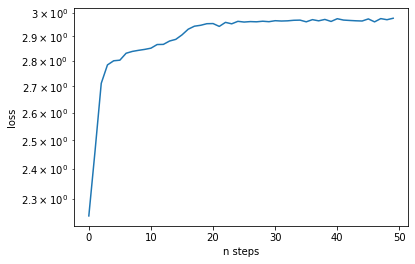

In [118]:
n_filt = 1
a = np.ones(n_filt)
h = lfilter(a,a.sum(),history.r_loss[:])
ax = plt.subplot()
ax.plot(h[n_filt-1:])
# h = lfilter(a,a.sum(),history.loss[:])
# ax.plot(h[n_filt:])
ax.set_yscale('log')
plt.xlabel("n steps")
plt.ylabel("loss")

In [34]:
modelNL, encoderNL, decoderNL = GetAEStaggeredNL(input_shapes,n_latent)
fd_weight = 0.003
modelNL.load_weights("MLmodels/NLsweep/NS_10D_NLfd"+str(fd_weight))
x = [u,v,p]
x_r = modelNL(x)
loss,r_loss,r_u_loss,r_v_loss,r_p_loss,fd_loss = ae_loss_function(x,x_r,r_weights,fd_weight,prob)
tf.reduce_mean(loss)

<tf.Tensor: shape=(), dtype=float32, numpy=0.046168186>

In [5]:
def Evaluate(model,u,v,p,prob,n_batch=32):
    u_r,v_r,p_r = model([u,v,p])
    mse_u,mse_v,mse_p = tf.reduce_mean(tf.square(u-u_r)),tf.reduce_mean(tf.square(v-v_r)),tf.reduce_mean(tf.square(p-p_r))
    u_res,v_res,con_res = tf.reduce_mean(u_res_loss(u_r,v_r,p_r,prob)),tf.reduce_mean(v_res_loss(u_r,v_r,p_r,prob)),tf.reduce_mean(con_res_loss(u_r,v_r,prob))
    return mse_u.numpy(),mse_v.numpy(),mse_p.numpy(),u_res.numpy(),v_res.numpy(),con_res.numpy()
    
prob = sf.GetProblem(30,1)
modelNL, encoderNL, decoderNL = GetAEStaggeredNL(input_shapes,n_latent)
fd_weight = 0.03
modelNL.load_weights("MLmodels/NLsweep/NS_10D_NLfd"+str(fd_weight))
mse_u,mse_v,mse_p,u_res,v_res,con_res = Evaluate(modelNL,u,v,p,prob)
print(mse_u,mse_v,mse_p,u_res,v_res,con_res)
model, encoder, decoder = GetAEStaggered(input_shapes,n_latent)
fd_weight = 0.03
model.load_weights("MLmodels/Lsweep/NS_10D_Lfd"+str(fd_weight))
mse_u,mse_v,mse_p,u_res,v_res,con_res = Evaluate(model,u,v,p,prob)
print(mse_u,mse_v,mse_p,u_res,v_res,con_res)
#0.17529473 0.14274271 2.1171238 4.07839e-06 4.7902345e-06 4.3801553e-08

0.08430786 0.08410816 0.5892365 1.4646123e-05 1.462442e-05 4.0871182e-08
0.18652311 0.25092146 2.2269685 1.7638864e-05 2.1192807e-05 1.8971114e-08


In [11]:
model, encoder, decoder = GetAEStaggered(input_shapes,n_latent)
model.load_weights("MLmodels/NS_10D_Lv4")
modelNL, encoderNL, decoderNL = GetAEStaggeredNL(input_shapes,n_latent)
modelNL.load_weights("MLmodels/NS_10D_NLv5")

In [11]:
def Evaluate2(model,u,v,p,prob,n_batch=32):
    u_r,v_r,p_r = model([u,v,p])
    mse_u,mse_v,mse_p = tf.reduce_mean(tf.square(u-u_r),axis=(1,2)),tf.reduce_mean(tf.square(v-v_r),axis=(1,2)),tf.reduce_mean(tf.square(p-p_r),axis=(1,2))
    u_res,v_res,con_res = u_res_loss(u_r,v_r,p_r,prob),v_res_loss(u_r,v_r,p_r,prob),con_res_loss(u_r,v_r,prob)
    return mse_u.numpy(),mse_v.numpy(),mse_p.numpy(),u_res.numpy(),v_res.numpy(),con_res.numpy()

mse_uNL,mse_vNL,mse_pNL,u_resNL,v_resNL,con_resNL = Evaluate2(modelNL,u,v,p,prob)
mse_uL,mse_vL,mse_pL,u_resL,v_resL,con_resL = Evaluate2(model,u,v,p,prob)

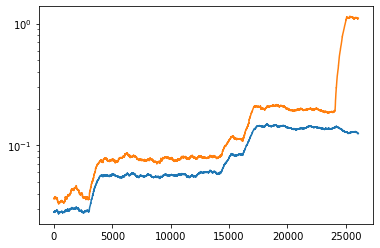

In [13]:
n_filt = 1000
a = np.ones(n_filt)
h = lfilter(a,a.sum(),mse_uNL)
ax = plt.subplot()
ax.plot(h[n_filt-1:])
a = np.ones(n_filt)
h = lfilter(a,a.sum(),mse_uL)
ax.plot(h[n_filt-1:])
ax.set_yscale('log')

In [174]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


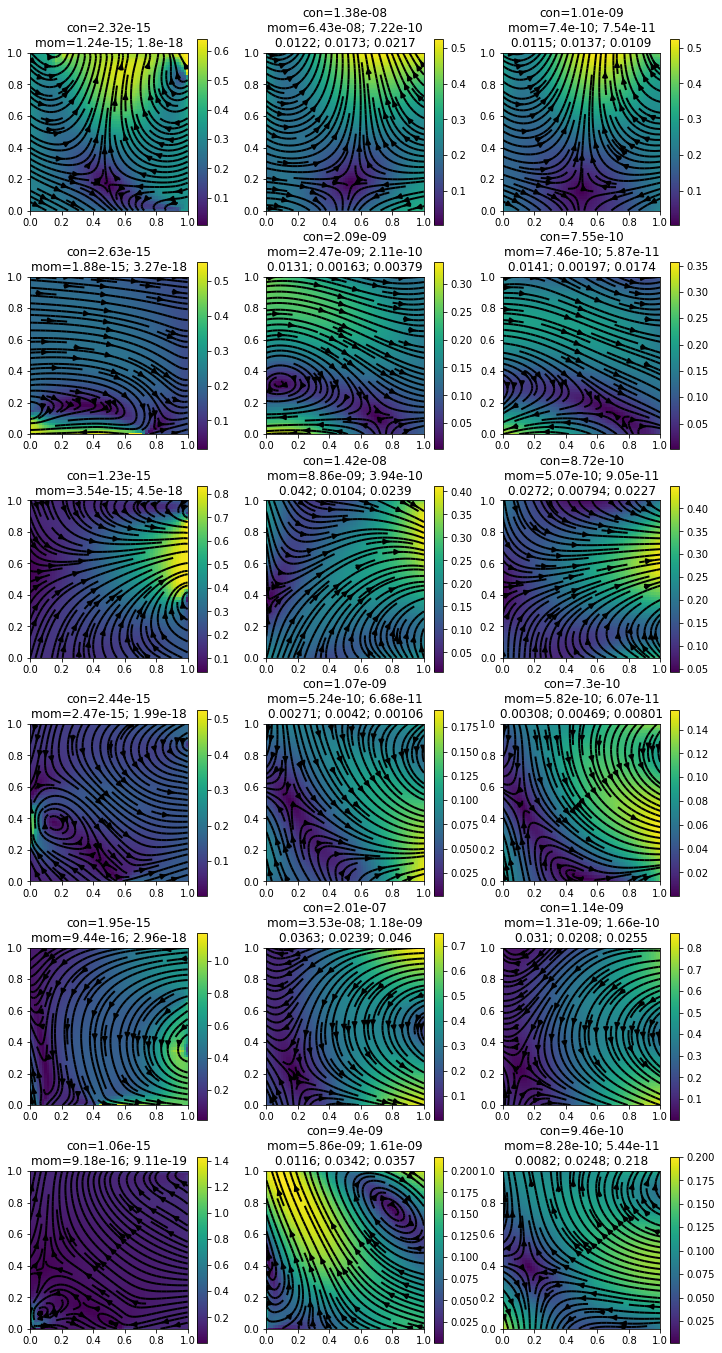

In [85]:
def PlotFlow(u,v,prob,ax):
    X_n,Y_n = np.meshgrid(prob.xc_u,prob.yc_v)
    u_n = (u[:,:-1]+u[:,1:])/2
    v_n = (v[:-1,:]+v[1:,:])/2
    u_n = np.transpose(u_n)
    v_n = np.transpose(v_n)
    X,Y = np.meshgrid(np.linspace(0,1,u_n.shape[0]*2),np.linspace(0,1,u_n.shape[1]*2))
    points_n = np.concatenate([X_n.reshape(X_n.size,1),Y_n.reshape(Y_n.size,1)],axis=1)
    values_n = np.concatenate([u_n.reshape(u_n.size,1),v_n.reshape(v_n.size,1)],axis=1)
    interp = LinearNDInterpolator(points_n, values_n)
    values_i = interp(X,Y)
    u_c = values_i[:,:,0]
    v_c = values_i[:,:,1]
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    c = ax.pcolormesh(X,Y,np.sqrt(u_c**2+v_c**2))
    plt.colorbar(c)
    ax.streamplot(X,Y,u_c,v_c,color="k",linewidth=2,density=1)
    plt.gca().set_aspect('equal', adjustable='box')

def Compare(n,model1,model2,u,v,p,prob):
    n = min(n,u.shape[0])
    u_r1,v_r1,p_r1 = model1([u[:n],v[:n],p[:n]])
    u_r1,v_r1,p_r1 = u_r1.numpy(),v_r1.numpy(),p_r1.numpy()
    u_r2,v_r2,p_r2 = model2([u[:n],v[:n],p[:n]])
    u_r2,v_r2,p_r2 = u_r2.numpy(),v_r2.numpy(),p_r2.numpy()
    # weights = np.array([1/u.var(),1/v.var(),1/p.var()])
    mse_u1,mse_v1,mse_p1 = np.square(u[:n]-u_r1).mean((1,2)),np.square(v[:n]-v_r1).mean((1,2)),np.square(p[:n]-p_r1).mean((1,2))
    mse_u2,mse_v2,mse_p2 = np.square(u[:n]-u_r2).mean((1,2)),np.square(v[:n]-v_r2).mean((1,2)),np.square(p[:n]-p_r2).mean((1,2))
    plt.figure(figsize=(12,4*n))
    for i in tqdm(range(n)):
        ax = plt.subplot(n,3,3*i+1)
        PlotFlow(u[i],v[i],prob,ax)
        ax.title.set_text("con={:.3g}\nmom={:.3g}; {:.3g}".format(float(u_res_loss(u[i:i+1],v[i:i+1],p[i:i+1],prob)),float(v_res_loss(u[i:i+1],v[i:i+1],p[i:i+1],prob)),float(con_res_loss(u[i:i+1],v[i:i+1],prob))))
        ax = plt.subplot(n,3,3*i+2)
        PlotFlow(u_r1[i],v_r1[i],prob,ax)
        ax.title.set_text("con={:.3g}\nmom={:.3g}; {:.3g}\n{:.3g}; {:.3g}; {:.3g}".format(float(u_res_loss(u_r1[i:i+1],v_r1[i:i+1],p_r1[i:i+1],prob)),float(v_res_loss(u_r1[i:i+1],v_r1[i:i+1],p_r1[i:i+1],prob)),float(con_res_loss(u_r1[i:i+1],v_r1[i:i+1],prob)),mse_u1[i],mse_v1[i],mse_p1[i]))
        ax = plt.subplot(n,3,3*i+3)
        PlotFlow(u_r2[i],v_r2[i],prob,ax)
        ax.title.set_text("con={:.3g}\nmom={:.3g}; {:.3g}\n{:.3g}; {:.3g}; {:.3g}".format(float(u_res_loss(u_r2[i:i+1],v_r2[i:i+1],p_r2[i:i+1],prob)),float(v_res_loss(u_r2[i:i+1],v_r2[i:i+1],p_r2[i:i+1],prob)),float(con_res_loss(u_r2[i:i+1],v_r2[i:i+1],prob)),mse_u2[i],mse_v2[i],mse_p2[i]))
    plt.show()

# index = 20
# modelPathNL = "MLmodels/NS_10D_NLv4"
# modelNL, encoderNL, decoderNL = GetAEStaggeredNL(input_shapes,n_latent)
# modelNL.load_weights(modelPathNL)
# u_r,v_r,p_r = modelNL([u[index:index+1],v[index:index+1],p[index:index+1]])
# af.PlotFlow(u[index],v[index],prob)
# af.PlotFlow(u_r[0],v_r[0],prob)
# print(af.CalcContinuityResiduals(u_r[0].numpy(),v_r[0].numpy(),prob),af.CalcMomentumResiduals(u_r[0].numpy(),v_r[0].numpy(),p_r[0].numpy(),prob))
# u_r,v_r,p_r = model([u[index:index+1],v[index:index+1],p[index:index+1]])
# af.PlotFlow(u_r[0],v_r[0],prob)
# print(af.CalcContinuityResiduals(u_r[0].numpy(),v_r[0].numpy(),prob),af.CalcMomentumResiduals(u_r[0].numpy(),v_r[0].numpy(),p_r[0].numpy(),prob))

index = 0
Compare(6,model,modelNL,u[index:index+100],v[index:index+100],p[index:index+100],prob)


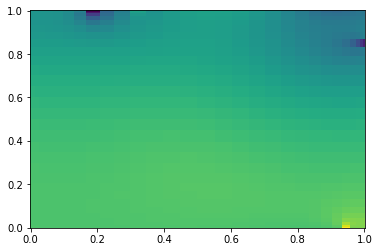

In [361]:
plt.pcolormesh(prob.X_p,prob.Y_p,p[0])

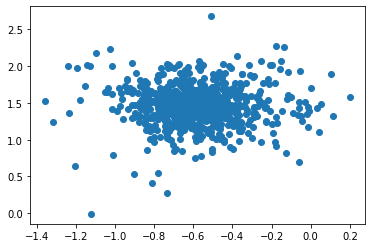

In [37]:
plt.scatter(mean[:,0],mean[:,1])
# plt.hist(mean[:,2],20)

In [49]:
mean = encoderNL([u[:1000],v[:1000],p[:1000]]).numpy()
mean.var(0)

array([0.04427498, 0.09379897, 0.07361505, 0.07111935, 0.06048379,
       0.05257916, 0.06702735, 0.08621853, 0.06300593, 0.05944971],
      dtype=float32)

In [76]:
def SubplotFlow(a,b,u,v,prob):
    n = min(a*b,u.shape[0])
    plt.figure(figsize=(14,14))
    for i in tqdm(range(n)):
        X_n,Y_n = np.meshgrid(prob.xc_u,prob.yc_v)
        u_n = (u[i,:,:-1]+u[i,:,1:])/2
        v_n = (v[i,:-1,:]+v[i,1:,:])/2
        u_n = np.transpose(u_n)
        v_n = np.transpose(v_n)
        X,Y = np.meshgrid(np.linspace(0,1,u_n.shape[0]*2),np.linspace(0,1,u_n.shape[1]*2))
        points_n = np.concatenate([X_n.reshape(X_n.size,1),Y_n.reshape(Y_n.size,1)],axis=1)
        values_n = np.concatenate([u_n.reshape(u_n.size,1),v_n.reshape(v_n.size,1)],axis=1)
        interp = LinearNDInterpolator(points_n, values_n)
        values_i = interp(X,Y)
        u_c = values_i[:,:,0]
        v_c = values_i[:,:,1]
        ax = plt.subplot(a,b,i+1)
        ax.set_ylim([0,1])
        ax.set_xlim([0,1])
        c = ax.pcolormesh(X,Y,np.sqrt(u_c**2+v_c**2))
        plt.colorbar(c)
        ax.streamplot(X,Y,u_c,v_c,color="k",linewidth=2,density=1)
        plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [ ]:
n_latent = 10
model_l,encoder_l,decoder_l = GetAE((n_image,n_image,3),n_latent)
optimizer = tf.keras.optimizers.Adam(0.0001)
model_l.compile(loss='mse', optimizer=optimizer,metrics=['mse'])
history_l = model_l.fit(x_train,x_train,epochs=200,batch_size=128,shuffle=True)

In [131]:
u_r,v_r,p_r = model({'input_u':u[:100],'input_v':v[:100],'input_p':p[:100]})

In [37]:
def GetEncoder1(n_latent,input_shape):
    input_imag = Input(shape=input_shape, name='encoder_input')
    x = Flatten()(input_imag)
    latent = Dense(n_latent)(x)
    encoder = Model(input_imag,latent,name="encoder")
    return encoder

def GetDecoder(n_latent,input_shape):
    input_latent = Input(shape=(n_latent,))
    x = Dense(input_shape[0]*input_shape[1]*input_shape[2],use_bias=False)(input_latent)
    x = Reshape((input_shape[0],input_shape[1],input_shape[2]))(x)
    decoder = Model(input_latent,x,name="decoder")
    return decoder

def GetAE(input_shape,n_latent):
    input_imag = Input(shape=input_shape, name='encoder_input')
    encoder = GetEncoder1(n_latent,input_shape)
    decoder = GetDecoder(n_latent,input_shape)
    model = Model(input_imag, decoder(encoder(input_imag)))
    
    return model, encoder, decoder

In [141]:
def getXtrain(order_bc,continuos=False):
    if continuos:
        con_str = "C"
    else:
        con_str = "DC"
    u = np.load(r"DataDC/dataset"+con_str+"_u_30_1_"+str(order_bc)+".npy")
    v = np.load(r"DataDC/dataset"+con_str+"_v_30_1_"+str(order_bc)+".npy")
    p = np.load(r"DataDC/dataset"+con_str+"_p_30_1_"+str(order_bc)+".npy")
    u_train = (u[:,1:,1:-1]+u[:,:-1,1:-1])/2
    u_train = np.expand_dims(u_train,axis=-1)
    v_train = (v[:,1:-1,1:]+v[:,1:-1,:-1])/2
    v_train = np.expand_dims(v_train,axis=-1)
    p_train = p
    p_train = np.expand_dims(p_train,axis=-1)
    x_train = np.concatenate([u_train,v_train,p_train],axis=3)
    return x_train

x_train = np.concatenate([getXtrain(1),getXtrain(2),getXtrain(3),getXtrain(5),getXtrain(4,True)],axis=0)
# x_train2 = getXtrain(2)
# x_train5 = getXtrain(5)
# xRe_max = np.max(np.sqrt(x_train[:,:,:,0]**2+x_train[:,:,:,1]**2),axis=(1,2))
# xRe_mean = np.mean(np.sqrt(x_train[:,:,:,0]**2+x_train[:,:,:,1]**2),axis=(1,2))
x_train.shape

(23067, 30, 30, 3)

In [6]:
np.isnan(x_train).any()

False

In [38]:
n_image = 30
n_latent = 10
model_l,encoder_l,decoder_l = GetAE((n_image,n_image,3),n_latent)
optimizer = tf.keras.optimizers.Adam(0.0001)
model_l.compile(loss='mse', optimizer=optimizer,metrics=['mse'])
history_l = model_l.fit(x_train,x_train,epochs=200,batch_size=128,shuffle=True)

Epoch 1/200
149/149 [==============================] - 4s 9ms/step - loss: 7.5552 - mse: 7.5552
Epoch 2/200
149/149 [==============================] - 1s 6ms/step - loss: 1.6307 - mse: 1.6307
Epoch 3/200
149/149 [==============================] - 1s 7ms/step - loss: 1.4433 - mse: 1.4433
Epoch 4/200
149/149 [==============================] - 1s 8ms/step - loss: 1.4386 - mse: 1.4386
Epoch 5/200
149/149 [==============================] - 1s 7ms/step - loss: 1.4340 - mse: 1.4340
Epoch 6/200
149/149 [==============================] - 1s 6ms/step - loss: 1.4319 - mse: 1.4319
Epoch 7/200
149/149 [==============================] - 1s 7ms/step - loss: 1.4274 - mse: 1.4274
Epoch 8/200
149/149 [==============================] - 1s 8ms/step - loss: 1.4200 - mse: 1.4200
Epoch 9/200
149/149 [==============================] - 1s 7ms/step - loss: 1.4119 - mse: 1.4119
Epoch 10/200
149/149 [==============================] - 1s 6ms/step - loss: 1.4019 - mse: 1.4019
Epoch 11/200
149/149 [=================

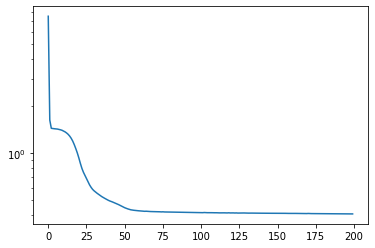

In [39]:
plt.plot(history_l.history['mse'])
# plt.plot(history_l.history['val_mse'])
plt.gca().set_yscale("log")
# plt.legend(["train","validation"])

100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


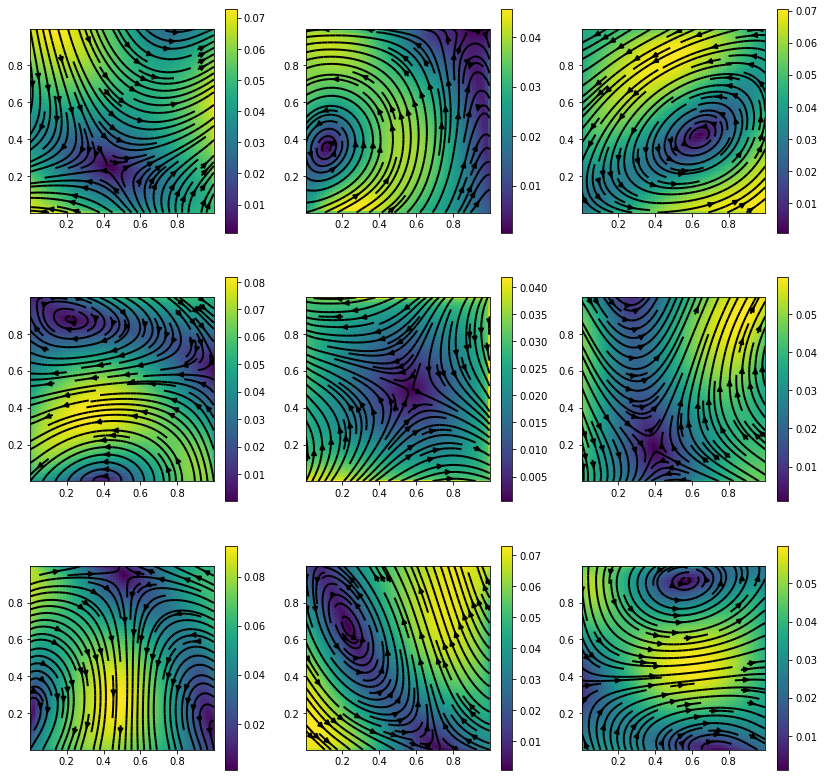

In [163]:
eig = decoder.trainable_variables[0].numpy().reshape(n_latent,30,30,3)
af.PlotX(3,3,eig,prob)

100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


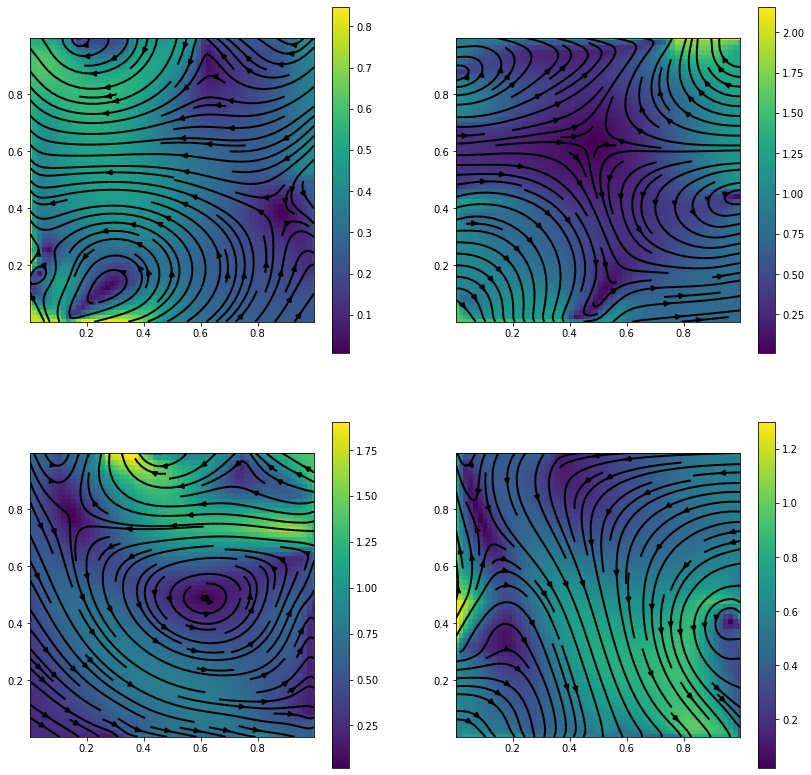

100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


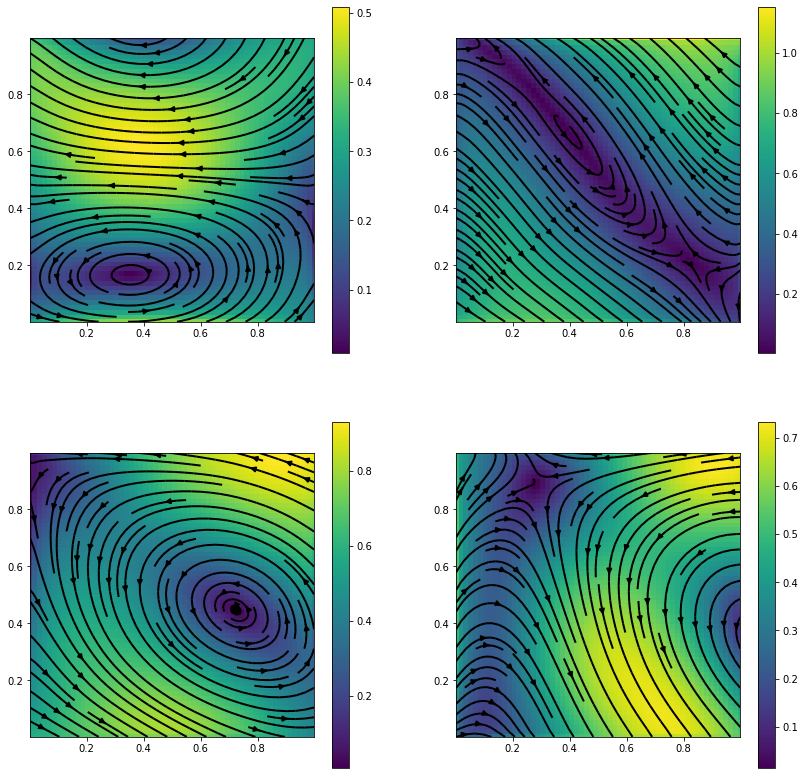

In [180]:
indexes = np.arange(x_train.shape[0])
np.random.shuffle(indexes)
x_train = x_train[indexes]
x_sample = x_train[7007:]
x_recon = model(x_sample).numpy()
af.PlotX(2,2,x_sample,prob)
af.PlotX(2,2,x_recon,prob)

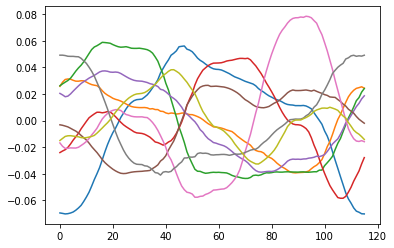

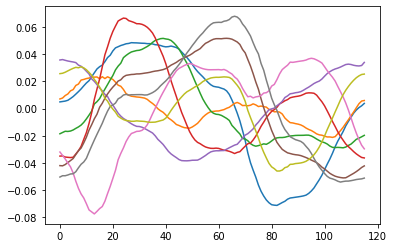

In [166]:
def GetBoundary(x):
    if (len(x.shape)==4):
        u_n = x[:,:,:,0]
        v_n = x[:,:,:,1]
        u_bc = np.concatenate([u_n[:,:-1,0],u_n[:,-1,:-1],u_n[:,1:,-1][:,::-1],u_n[:,0,1:][:,::-1]],axis=-1)
        v_bc = np.concatenate([v_n[:,:-1,0],v_n[:,-1,:-1],v_n[:,1:,-1][:,::-1],v_n[:,0,1:][:,::-1]],axis=-1)
    else:
        u_n = x[:,:,0]
        v_n = x[:,:,1]
        u_bc = np.concatenate([u_n[:-1,0],u_n[-1,:-1],u_n[1:,-1][::-1],u_n[0,1:][::-1]])
        v_bc = np.concatenate([v_n[:-1,0],v_n[-1,:-1],v_n[1:,-1][::-1],v_n[0,1:][::-1]])
    return u_bc,v_bc

u_bc,v_bc = GetBoundary(eig)
plt.plot(np.transpose(u_bc))
plt.show()
plt.plot(np.transpose(v_bc))
plt.show()

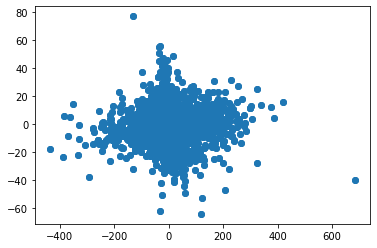

In [177]:
mean = encoder(x_train[:]).numpy()
# plt.scatter(mean[:,0],mean[:,1])
pca = PCA(n_components=2)
pca_fit = pca.fit(mean)
points = pca_fit.transform(mean)
plt.scatter(points[:,0],points[:,1])


In [221]:
n_image = 30
n_latent = 10
model,encoder,decoder = GetModelAENL(n_latent,(n_image,n_image,3))
optimizer = tf.keras.optimizers.Adam(0.00001)
checkpoint_filepath = 'MLmodels/NS_10DAE_NLv1.ckpt'
model.load_weights(checkpoint_filepath)
model.compile(loss='mse', optimizer=optimizer,metrics=['mse'])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True)
history_nl = model.fit(x_train,x_train,epochs=2,batch_size=128,shuffle=True,callbacks=[model_checkpoint_callback])
plt.plot(history_nl.history['mse'])
plt.gca().set_yscale("log")
plt.legend(["train","validation"])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:

Apd_x = prob.mu * prob.dy_p/prob.lx_u
Apd_y = prob.mu * prob.dx_p/prob.ly_u

In [63]:
def GetEncoderNL(n_latent,image):
    input_e = Input(image)
    x = Flatten()(input_e)
    x = Dense(100,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dense(100,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    mean = Dense(n_latent)(x)
    log_var = Dense(n_latent)(x)
    encoder = Model(input_e,[mean,log_var])
    return encoder

def GetEncoderNL_AE(n_latent,image):
    input_e = Input(image)
    x = Flatten()(input_e)
    x = Dense(100,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dense(100,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    mean = Dense(n_latent)(x)
    encoder = Model(input_e,mean)
    return encoder

def GetDecoderNL(n_latent,image):
    input_d = Input(n_latent)
    x = Dense(100,activation='sigmoid')(input_d)
    x = BatchNormalization()(x)
    x = Dense(100,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dense(image[0]*image[1]*image[2])(x)
    out_d = Reshape((image[0],image[1],image[2]))(x)
    decoder = Model(input_d,out_d)
    return decoder

def GetEncoderNL2(n_latent,image):
    input_e = Input(image)
    x = Conv2D(8,10,activation="sigmoid",strides=(2,2))(input_e)
    x = BatchNormalization()(x)
    x = Conv2D(16,10,activation="sigmoid",strides=(2,2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    mean = Dense(n_latent)(x)
    log_var = Dense(n_latent)(x)
    encoder = Model(input_e,[mean,log_var])
    return encoder

def GetDecoderNL2(n_latent,image):
    input_d = Input(n_latent)
    x = Dense(20,activation='sigmoid')(input_d)
    x = BatchNormalization()(x)
    x = Dense(20,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dense(image[0]*image[1])(x)
    out_d = Reshape((image[0],image[1],1))(x)
    decoder = Model(input_d,out_d)
    return decoder

def GetModelAENL(n_latent,image):
    input_e = Input(image)
    encoder = GetEncoderNL_AE(n_latent,image)
    decoder = GetDecoderNL(n_latent,image)
    model = Model(input_e,decoder(encoder(input_e)))
    return model,encoder,decoder

class ModelVAE_NL(Model):
    
    def __init__(self,n_latent,input):
        super(ModelVAE_NL,self).__init__()
        self.n_latent = n_latent
        self.encoder = GetEncoderNL(n_latent,input)
        self.decoder = GetDecoderNL(n_latent,input)
        
    def sample(self,z_mean,z_logsigma):
        batch, latent_dim = z_mean.shape
        epsilon = tf.random.normal(shape=(batch, latent_dim))
        z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
        return z
    
    def encode(self,x):
        mean, log_var = self.encoder(x)
        z = self.sample(mean,log_var)
        return z, mean, log_var
        
    def decode(self,z):
        x_r = self.decoder(z)
        return x_r
        
    def call(self,x):
        z, mean, log_var = self.encode(x)
        x_r = self.decode(z)
        return x_r, mean, log_var
    
    def reconstruct(self,x):
        mean,_ = self.encoder(x)
        x_r = self.decoder(mean)
        return x_r
    
class ModelVAE_NL2(Model):
    
    def __init__(self,n_latent,n_input):
        super(ModelVAE_NL2,self).__init__()
        self.n_latent = n_latent
        self.encoder = GetEncoderNL2(n_latent,(n_input,n_input,1))
        self.decoder = GetDecoderNL2(n_latent,(n_input,n_input,1))
        
    def sample(self,z_mean,z_logsigma):
        batch, latent_dim = z_mean.shape
        epsilon = tf.random.normal(shape=(batch, latent_dim))
        z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
        return z
    
    def encode(self,x):
        mean, log_var = self.encoder(x)
        z = self.sample(mean,log_var)
        return z, mean, log_var
        
    def decode(self,z):
        x_r = self.decoder(z)
        return x_r
        
    def call(self,x):
        z, mean, log_var = self.encode(x)
        x_r = self.decode(z)
        return x_r, mean, log_var
    
    def reconstruct(self,x):
        mean,_ = self.encoder(x)
        x_r = self.decoder(mean)
        return x_r
    
# def vae_loss_function(x, x_recon, mu, logsigma,kl_weight,A,fd_weight):
#     latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
#     reconstruction_loss = tf.reduce_mean(tf.square(x-x_recon), axis=(1,2,3))
#     fd_loss = tf.reduce_mean(tf.square(tf.matmul(A,tf.reshape(x_recon,\
#         shape=(x_recon.shape[0],x_recon.shape[1]*x_recon.shape[2],1)))),axis=(1,2))
#     vae_loss = kl_weight * latent_loss + reconstruction_loss + fd_weight * fd_loss
#     return vae_loss,reconstruction_loss,latent_loss,fd_loss

def vae_loss_function(x, x_recon, mu, logsigma,kl_weight):
    latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
    reconstruction_loss = tf.reduce_mean(tf.square(x-x_recon), axis=(1,2,3))
    vae_loss = kl_weight * latent_loss + reconstruction_loss
    return vae_loss,reconstruction_loss,latent_loss

@tf.function
def train_step_VAE(modelVAE,optimizer,images,kl_weight):
    with tf.GradientTape() as tape:
        
        (images_r, mu, log_vat) = modelVAE(images)
        images = tf.cast(images,tf.float32)
        loss,r_loss,l_loss = vae_loss_function(images,images_r, mu, log_vat,kl_weight)

    grads = tape.gradient(loss,modelVAE.trainable_variables)
    optimizer.apply_gradients(zip(grads,modelVAE.trainable_variables))
    return loss,r_loss,l_loss

class History():
    def __init__(self,n):
        self.loss = np.zeros(n)
        self.r_loss = np.zeros(n)
        self.l_loss = np.zeros(n)
        self.fd_loss = np.zeros(n)
        
    def add(self,history):
        self.loss = np.concatenate([self.loss,history.loss],axis=0)
        self.r_loss = np.concatenate([self.r_loss,history.r_loss],axis=0)
        self.l_loss = np.concatenate([self.l_loss,history.l_loss],axis=0)
        self.fd_loss = np.concatenate([self.fd_loss,history.fd_loss],axis=0)

def train_VAE(modelVAE,optimizer,x_train,n_epochs,n_batch,kl_weight=0.005,modelPath=None):
    n_steps = n_epochs*len(range(0,x_train.shape[0],n_batch))
    history = History(n_steps)
    index = 0
    loss_min = np.inf
    for epoch in range(n_epochs):
        i = np.arange(x_train.shape[0])
        np.random.shuffle(i)
        x_train = x_train[i,:,:,:]
#         x_train_shuffled = tf.cast(x_train_shuffled,tf.float32)
        loss_epoch = np.zeros((x_train.shape[0]))

        for batch in range(0,x_train.shape[0],n_batch):
            loss,r_loss,l_loss = train_step_VAE(modelVAE,optimizer,x_train[batch:batch+n_batch],kl_weight)
            history.loss[index] = tf.reduce_mean(loss)
            history.r_loss[index] = tf.reduce_mean(r_loss)
            history.l_loss[index] = tf.reduce_mean(l_loss)
            loss_epoch[batch:batch+loss.shape[0]] = loss
            # history.fd_loss[index] = tf.reduce_mean(fd_loss)
            
            print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}".format(epoch+1,n_epochs, 100*batch/x_train.shape[0],history.loss[index]),end="\t") #
            index+=1
            
        print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}".format(epoch+1,n_epochs, 100,loss_epoch.mean()),end="\n")
        if (modelPath!=None) and (loss_epoch.mean()<loss_min):
            try:
                modelVAE.save_weights(modelPath)
            except:
                print("unable to save")
            
    return history

In [59]:
n_batch = 128
n_epochs = 1000
kl_weight = 0.00000 #kl_weight = 0.0005
n_latent = 10
input_shape = x_train[0].shape
lr = 0.00005

# modelVAE = ModelVAE_NL(n_latent,input_shape)
modelVAE.load_weights("MLmodels/NS_10D_NLv4")
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

lhistory_part = train_VAE(modelVAE,optimizer,x_train,n_epochs,n_batch,kl_weight,"MLmodels/NS_10D_NLv4")
print()
if ('lhistory' in locals()):
    lhistory.add(lhistory_part)
    print("add")
else:
    lhistory = lhistory_part
    print("define")

1/1000 epochs - 100%; loss = 0.314863											
2/1000 epochs - 100%; loss = 0.31264											
3/1000 epochs - 100%; loss = 0.312719										
4/1000 epochs - 100%; loss = 0.311931						
5/1000 epochs - 100%; loss = 0.322816									
6/1000 epochs - 100%; loss = 0.341197								
7/1000 epochs - 100%; loss = 0.314411								
8/1000 epochs - 100%; loss = 0.31061								
9/1000 epochs - 100%; loss = 0.309191									
10/1000 epochs - 100%; loss = 0.312384					
11/1000 epochs - 100%; loss = 0.309441							
12/1000 epochs - 100%; loss = 0.312126								
13/1000 epochs - 100%; loss = 0.311699										
14/1000 epochs - 100%; loss = 0.309923								
15/1000 epochs - 100%; loss = 0.311328								
16/1000 epochs - 100%; loss = 0.351165								
17/1000 epochs - 100%; loss = 0.333627								
18/1000 epochs - 100%; loss = 0.316081							
19/1000 epochs - 100%; loss = 0.313857							
20/1000 epochs - 100%; loss = 0.309533							
21/1000 epochs - 100%; loss = 0.308761									
22/1000 epochs - 100

In [64]:
# n_latent = 10
# input_shape = x_train[0].shape
# modelVAE = ModelVAE_NL(n_latent,input_shape)
# modelVAE.save_weights("MLmodels/NS_10D_NLv3")
# modelVAE.summary()
# del lhistory
CalcMSE(x_train,modelVAE,True)

0.29830477633972285

In [7]:
n_latent = 10
input_shape = x_train[0].shape
modelVAE = ModelVAE_NL(n_latent,input_shape)
modelVAE.load_weights("MLmodels/NS_10D_NLv4")

Text(0, 0.5, 'loss')

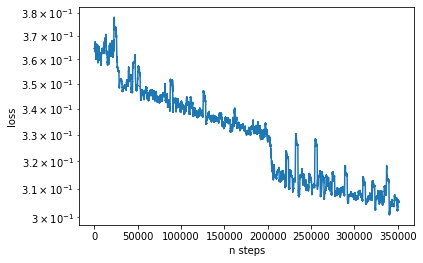

In [62]:
n_filt = 3000
a = np.ones(n_filt)
h = lfilter(a,a.sum(),lhistory.r_loss[600000:])
ax = plt.subplot()
ax.plot(h[n_filt:])
ax.set_yscale('log')
plt.xlabel("n steps")
plt.ylabel("loss")

[ 9.875863  10.11957    2.59854   10.618188   5.0039964  9.049072
 10.960879   8.792882   5.8818874  4.5814233]


array([0.00279572, 0.00195763, 0.00132052, 0.00044449, 0.0023282 ,
       0.00273622, 0.00189616, 0.00134158, 0.00158907, 0.00094126],
      dtype=float32)

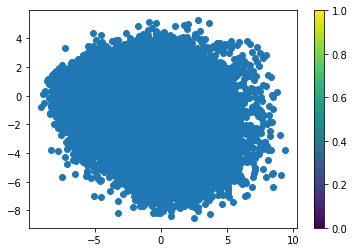

In [48]:
index = 2000
mean,logvar=modelVAE.encoder(x_train[:])
mean = mean.numpy()
a = mean.var(0)
i = np.where(a>0.1)
plt.scatter(mean[:,7],mean[:,8])
# pca = PCA(n_components=2)
# pca_fit = pca.fit(mean)
# points = pca_fit.transform(mean)
# plt.scatter(points[:,0],points[:,1],c=xRe_mean[:index])
plt.colorbar()
print(a)
var = np.exp(logvar)
var.mean(0)


100%|██████████| 16/16 [00:04<00:00,  3.50it/s]


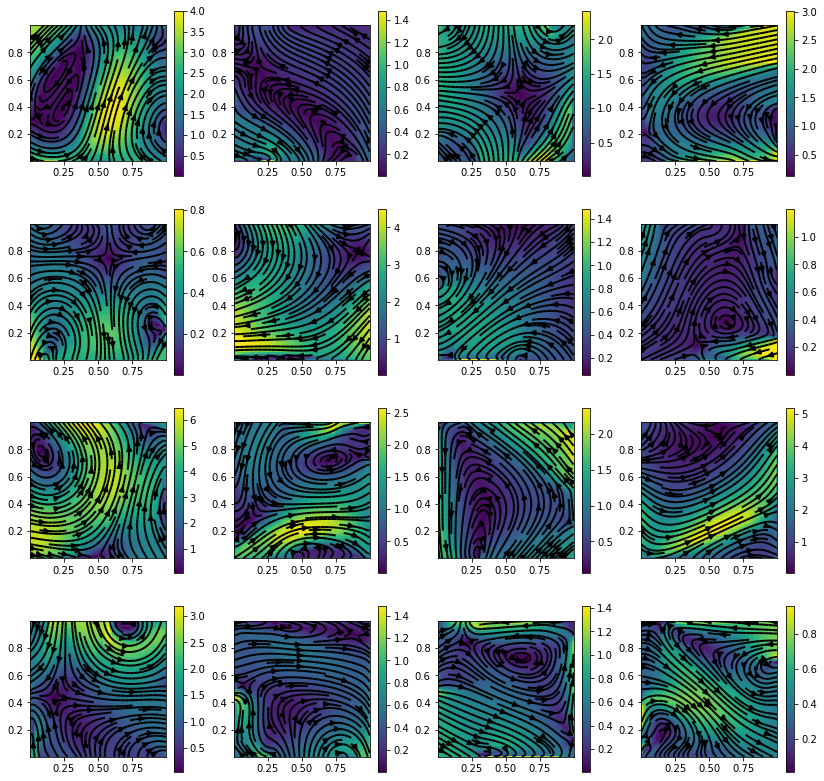

100%|██████████| 16/16 [00:04<00:00,  3.54it/s]


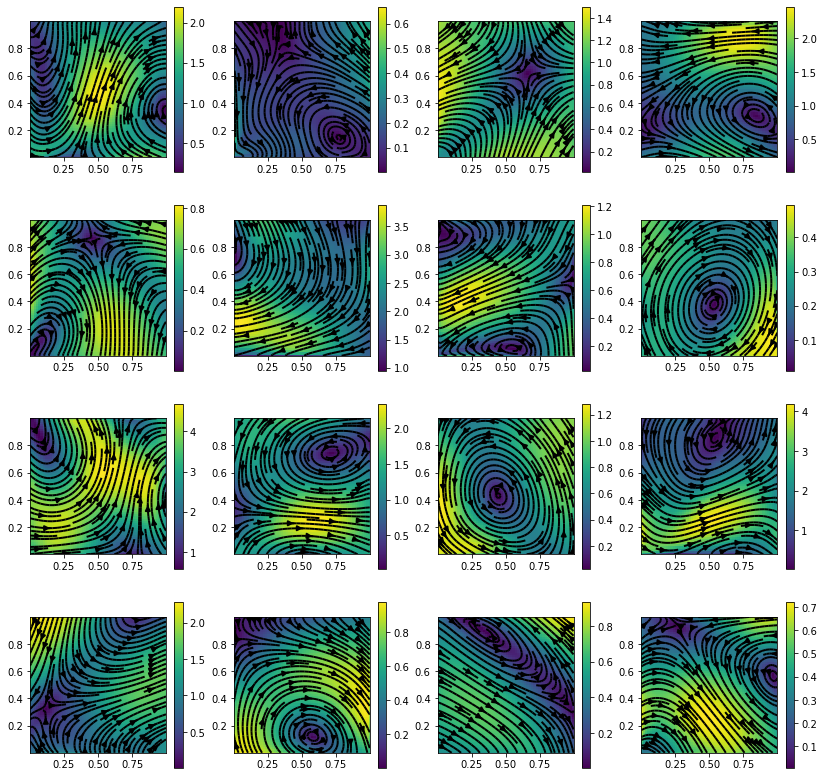

In [43]:
# np.exp(logvar.numpy().mean(0))
prob = sf.GetProblem(30,1)
indexes = np.arange(x_train.shape[0])
np.random.shuffle(indexes)
x_train = x_train[indexes]
x_sample = x_train[:]
x_recon = modelVAE.reconstruct(x_sample).numpy()
af.PlotX(4,4,x_sample,prob)
af.PlotX(4,4,x_recon,prob)

100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


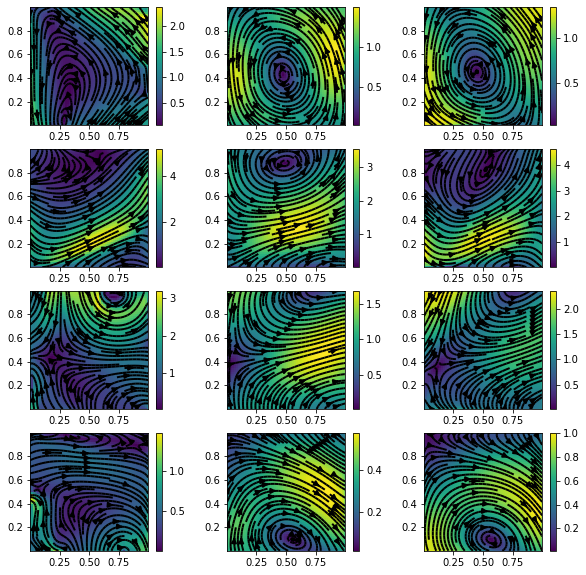

In [66]:
def plotX(x_train,prob):
    X_n,Y_n = prob.X_p,prob.Y_p
    x_lim = (prob.xc_p[0],prob.xc_p[-1])
    y_lim = (prob.yc_p[0],prob.yc_p[-1])
    u_n = x_train[:,:,0]
    v_n = x_train[:,:,1]
    # u_n = np.transpose(u_n)
    # v_n = np.transpose(v_n)
    X,Y = np.meshgrid(np.linspace(x_lim[0],y_lim[-1],u_n.shape[0]*2),np.linspace(y_lim[0],y_lim[-1],u_n.shape[1]*2))
    points_n = np.concatenate([X_n.reshape(X_n.size,1),Y_n.reshape(Y_n.size,1)],axis=1)
    values_n = np.concatenate([u_n.reshape(u_n.size,1),v_n.reshape(v_n.size,1)],axis=1)
    interp = LinearNDInterpolator(points_n, values_n)
    values_i = interp(X,Y)
    u_c = values_i[:,:,0]
    v_c = values_i[:,:,1]
    # ax = plt.subplot(a,b,i+1)
    plt.gca().set_ylim(x_lim)
    plt.gca().set_xlim(y_lim)
    c = plt.pcolormesh(X,Y,np.sqrt(u_c**2+v_c**2))
    plt.colorbar(c)
    plt.streamplot(X,Y,u_c,v_c,color="k",linewidth=2,density=1)
    plt.gca().set_aspect('equal', adjustable='box')

def CompareRecon(modelVAE,modelAE,x_train, a,prob):
    n = min(x_train.shape[0],a)
    x_r_nl = modelVAE.reconstruct(x_train[:n]).numpy()
    x_r_l = modelAE(x_train[:n]).numpy()
    plt.figure(figsize=(10,10))
    for i in tqdm(range(n)):
        plt.subplot(n,3,3*i+1)
        plotX(x_train[i],prob)
        plt.subplot(n,3,3*i+2)
        plotX(x_r_l[i],prob)
        plt.subplot(n,3,3*i+3)
        plotX(x_r_nl[i],prob)
        
        
CompareRecon(modelVAE,model_l,x_train[10:],4,prob)
# np.random.shuffle(x_train)
# af.PlotX(3,3,x_train[15000:],prob)

In [40]:
def CalcMSE(x_train,model,VAE):
    if VAE:
        x_r = model.reconstruct(x_train).numpy()
    else:
        x_r = model(x_train).numpy()
    mse = np.square(x_train-x_r).mean()
    return mse

mse_nl = CalcMSE(x_train,modelVAE,True)
mse_l = CalcMSE(x_train,model_l,False)
print(mse_l,mse_nl)

0.4062516523241656 0.3411044271056085
